# Vanilla GAN MNIST

### Import Packages

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("./MNIST_data/", one_hot= True)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


### Set hyperparameters

In [2]:
total_epoch = 100
batch_size = 100
learning_rate = 0.001
n_hidden = 256
n_input = 28 * 28
n_noise = 128 # noise size for generator

### Set placeholder

GAN is also kind of unsupervised learning. You don't need to set label data Y. But you set two placeholder X and Z. X is for real data set and Z is for inputting noise to generate fake data. Both X and Z are fed to discriminator.

In [3]:
X = tf.placeholder(tf.float32, [None, n_input])
Z = tf.placeholder(tf.float32, [None, n_noise])

### Set variables for Generator

First variable(G_W1) and bias(G_b1) are variables for hidden layer and second variable(G_W2) and bias(G_b2) are for output. The shape of second variable is correspond to input image shape which enter to discriminator.

In [4]:
G_W1 = tf.Variable(tf.random_normal([n_noise, n_hidden], stddev= 0.01)) # (n_noise, n_hidden)
G_b1 = tf.Variable(tf.zeros([n_hidden])) # (n_hidden,)
G_W2 = tf.Variable(tf.random_normal([n_hidden, n_input], stddev = 0.01)) # (n_hidden, n_input)
G_b2 = tf.Variable(tf.zeros([n_input])) # (n_input,)

### Set variables for Discriminator

I just set the hidden layer of discriminator similar to generator. The output of discriminator is 0 or 1 in order to distinguish real or fake image. 

We must set the same variable in discriminator 1) which distinguish real image and 2) another discriminator which tell the generated image. Only if same variable is used when distinguising, Discriminator can figure out the real/fake image characteristics.

In [5]:
D_W1 = tf.Variable(tf.random_normal([n_input, n_hidden], stddev= 0.01)) # (n_input, n_hidden)
D_b1 = tf.Variable(tf.zeros([n_hidden])) # (n_hidden,)
D_W2 = tf.Variable(tf.random_normal([n_hidden, 1], stddev = 0.01)) # (n_hidden, 1)
D_b2 = tf.Variable(tf.zeros([1])) # (1,)

### Set generator & discriminator

In [6]:
def generator(noise_z):
    # input : noise_z (None, n_noise)
    # output : output (None, 784)    
    
    hidden = tf.nn.relu(tf.matmul(noise_z, G_W1) + G_b1) # (None, n_hidden)
    output = tf.nn.relu(tf.matmul(hidden, G_W2) + G_b2) # (None, 784)
    return output

def discriminator(inputs):
    # input : inputs (None, 784)
    # output : output (None, 1)
    
    hidden = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1) # (None, n_hidden)
    output = tf.sigmoid(tf.matmul(hidden, D_W2) + D_b2) # (None, 1)
    
    return output

### Set noise generator

In [7]:
def get_noise(batch_size, n_noise):
    # output : random matrix (batch_size, n_noise)
    
    return np.random.normal(size = (batch_size, n_noise))

Generator creates fake image by using random noise z. Discriminator get two inputs, first, fake images by generator and second, real images. Discriminator judge what is real and fake.

In [8]:
G = generator(Z) # (None, 784)
D_gene = discriminator(G) # (None, 1)
D_real = discriminator(X) # (None, 1)

### Set loss

+ 1. loss which discriminator judges that fake image generated by generator is `fake.`
    - Example of counterfeit, this loss is relevent to **police.**
+ 2. loss which discriminator judges that fake image generated by generator is `real.`
    - Example of counterfeit, this loss is relevent to **counterfeiter**
    
For #1 loss of **police**, In order to train, D_real closes to '1'(discriminator judges that it's real) and D_gene closes to '0'(it's fake). SImply, `D_real` + `1- D_gene` makes loss.

In [9]:
loss_D = tf.reduce_mean(tf.log(D_real) + tf.log(1 - D_gene))

For #2 loss of **counterfeiter**, In order to train, only D_gene should be closed to '1'. It means that discriminator judge that fake images as real or, Generator(counterfeiter) deceives Discriminator(police).

In [10]:
loss_G = tf.reduce_mean(tf.log(D_gene))

Object of GAN training is to maximize the loss_D & loss_G. But loss_D & loss_G are dependent. Accordingly, their increse or decrease relation is not proportional. Somtimes, they have inverse relation. Therefore they have `adversarial relation`.(So we call this network as adversarial network).

### Set optimizer

**※ Caution :** <br>
Only discriminator variables are to be used only if you get loss_D. On the other hand, only generator variables must be used only if you get loss_G. By seperating this two loss, Getting loss_G doesn't change the discriminator variables and vice versa.

In [11]:
D_var_list = [D_W1, D_W2, D_b1, D_b2]
G_var_list = [G_W1, G_W2, G_b1, G_b2]

According to the GAN paper, loss must become maximum. But in most of deep learning framework(Tensorflow, Keras...), They supports only minimize optimizer. Therefore we set the **minus** to the `loss_G` and `loss_D`

In [12]:
train_D = tf.train.AdamOptimizer(learning_rate).minimize(-loss_D, var_list = D_var_list)
train_G = tf.train.AdamOptimizer(learning_rate).minimize(-loss_G, var_list = G_var_list)

### Set train

In [55]:
sess = tf.Session()

In [56]:
sess.run(tf.global_variables_initializer())

In [57]:
total_batch = int(mnist.train.num_examples / batch_size)

In [58]:
loss_val_D, loss_val_G = 0, 0

Epoch :    0,	 D loss : -1.4766 	 G loss : -0.7364
Epoch :    1,	 D loss : -1.3563 	 G loss : -0.8633
Epoch :    2,	 D loss : -1.1901 	 G loss : -0.9365
Epoch :    3,	 D loss : -1.2323 	 G loss : -0.9726
Epoch :    4,	 D loss : -1.7303 	 G loss : -0.6191
Epoch :    5,	 D loss : -1.1169 	 G loss : -1.4305
Epoch :    6,	 D loss : -1.7859 	 G loss : -0.5701
Epoch :    7,	 D loss : -1.3085 	 G loss : -0.9001
Epoch :    8,	 D loss : -1.8098 	 G loss : -0.5844
Epoch :    9,	 D loss : -1.7283 	 G loss : -0.6234
Epoch :   10,	 D loss : -1.4244 	 G loss : -0.7492


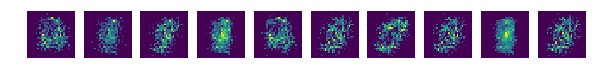

Epoch :   11,	 D loss : -1.4052 	 G loss : -0.7459
Epoch :   12,	 D loss : -1.2803 	 G loss : -0.9175
Epoch :   13,	 D loss : -1.4435 	 G loss : -1.3731
Epoch :   14,	 D loss : -1.5390 	 G loss : -0.7211
Epoch :   15,	 D loss : -1.6658 	 G loss : -0.6897
Epoch :   16,	 D loss : -1.2575 	 G loss : -0.8598
Epoch :   17,	 D loss : -1.4507 	 G loss : -0.8895
Epoch :   18,	 D loss : -1.5269 	 G loss : -0.6557
Epoch :   19,	 D loss : -1.4951 	 G loss : -0.6152
Epoch :   20,	 D loss : -1.5237 	 G loss : -0.6937


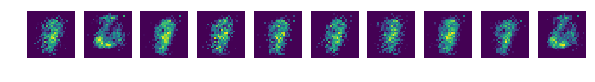

Epoch :   21,	 D loss : -1.5626 	 G loss : -0.6583
Epoch :   22,	 D loss : -1.4714 	 G loss : -0.6545
Epoch :   23,	 D loss : -1.4066 	 G loss : -0.9976
Epoch :   24,	 D loss : -1.3563 	 G loss : -0.7681
Epoch :   25,	 D loss : -1.2507 	 G loss : -1.0542
Epoch :   26,	 D loss : -1.3451 	 G loss : -0.7958
Epoch :   27,	 D loss : -1.4263 	 G loss : -0.6811
Epoch :   28,	 D loss : -1.5454 	 G loss : -0.6343
Epoch :   29,	 D loss : -1.3385 	 G loss : -0.7030
Epoch :   30,	 D loss : -1.3341 	 G loss : -1.0389


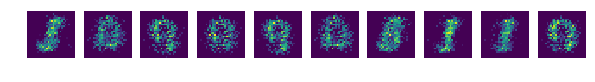

Epoch :   31,	 D loss : -1.3488 	 G loss : -0.7507
Epoch :   32,	 D loss : -1.4641 	 G loss : -0.6538
Epoch :   33,	 D loss : -1.3682 	 G loss : -0.7324
Epoch :   34,	 D loss : -1.3711 	 G loss : -0.9081
Epoch :   35,	 D loss : -1.4004 	 G loss : -0.9000
Epoch :   36,	 D loss : -1.4859 	 G loss : -0.7466
Epoch :   37,	 D loss : -1.4042 	 G loss : -0.9024
Epoch :   38,	 D loss : -1.3585 	 G loss : -0.9027
Epoch :   39,	 D loss : -1.5280 	 G loss : -0.7362
Epoch :   40,	 D loss : -1.3184 	 G loss : -0.8496


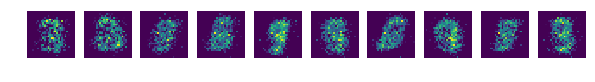

Epoch :   41,	 D loss : -1.2992 	 G loss : -0.9355
Epoch :   42,	 D loss : -1.3580 	 G loss : -0.8858
Epoch :   43,	 D loss : -1.4072 	 G loss : -0.5773
Epoch :   44,	 D loss : -1.2843 	 G loss : -0.7060
Epoch :   45,	 D loss : -1.4257 	 G loss : -0.6491
Epoch :   46,	 D loss : -1.3895 	 G loss : -0.7291
Epoch :   47,	 D loss : -1.4025 	 G loss : -0.6950
Epoch :   48,	 D loss : -1.4059 	 G loss : -0.7308
Epoch :   49,	 D loss : -1.4128 	 G loss : -0.6812
Epoch :   50,	 D loss : -1.3333 	 G loss : -0.7371


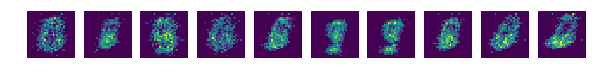

Epoch :   51,	 D loss : -1.3762 	 G loss : -0.7017
Epoch :   52,	 D loss : -1.3739 	 G loss : -0.6969
Epoch :   53,	 D loss : -1.3614 	 G loss : -0.7191
Epoch :   54,	 D loss : -1.3718 	 G loss : -0.7484
Epoch :   55,	 D loss : -1.3042 	 G loss : -0.8244
Epoch :   56,	 D loss : -1.3247 	 G loss : -0.9025
Epoch :   57,	 D loss : -1.5295 	 G loss : -0.8136
Epoch :   58,	 D loss : -1.4047 	 G loss : -0.7969
Epoch :   59,	 D loss : -1.3305 	 G loss : -0.7420
Epoch :   60,	 D loss : -1.4398 	 G loss : -0.7692


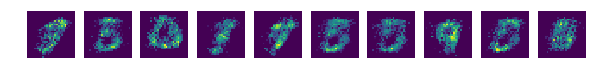

Epoch :   61,	 D loss : -1.2736 	 G loss : -0.8145
Epoch :   62,	 D loss : -1.3722 	 G loss : -0.6934
Epoch :   63,	 D loss : -1.3263 	 G loss : -0.7177
Epoch :   64,	 D loss : -1.3287 	 G loss : -0.7675
Epoch :   65,	 D loss : -1.3336 	 G loss : -0.8244
Epoch :   66,	 D loss : -1.6207 	 G loss : -0.7277
Epoch :   67,	 D loss : -1.4142 	 G loss : -0.8250
Epoch :   68,	 D loss : -1.5722 	 G loss : -0.9014
Epoch :   69,	 D loss : -1.2849 	 G loss : -0.8031
Epoch :   70,	 D loss : -1.3989 	 G loss : -0.7907


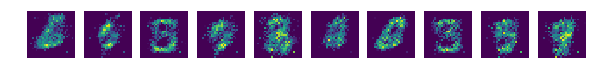

Epoch :   71,	 D loss : -1.4139 	 G loss : -0.7955
Epoch :   72,	 D loss : -1.5131 	 G loss : -0.6275
Epoch :   73,	 D loss : -1.2564 	 G loss : -0.8795
Epoch :   74,	 D loss : -1.3589 	 G loss : -0.6609
Epoch :   75,	 D loss : -1.4699 	 G loss : -0.6644
Epoch :   76,	 D loss : -1.4116 	 G loss : -0.7853
Epoch :   77,	 D loss : -1.2860 	 G loss : -1.1082
Epoch :   78,	 D loss : -1.3976 	 G loss : -0.8538
Epoch :   79,	 D loss : -1.2223 	 G loss : -0.8577
Epoch :   80,	 D loss : -1.2027 	 G loss : -0.9768


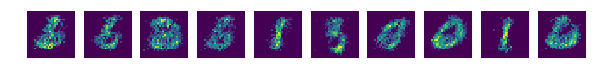

Epoch :   81,	 D loss : -1.2133 	 G loss : -0.8374
Epoch :   82,	 D loss : -1.2779 	 G loss : -0.8684
Epoch :   83,	 D loss : -1.3011 	 G loss : -0.8541
Epoch :   84,	 D loss : -1.3245 	 G loss : -0.8959
Epoch :   85,	 D loss : -1.3494 	 G loss : -0.7974
Epoch :   86,	 D loss : -1.2499 	 G loss : -0.8657
Epoch :   87,	 D loss : -1.2723 	 G loss : -0.7915
Epoch :   88,	 D loss : -1.2330 	 G loss : -0.9847
Epoch :   89,	 D loss : -1.2721 	 G loss : -0.8500
Epoch :   90,	 D loss : -1.3510 	 G loss : -0.8728


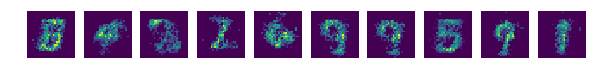

Epoch :   91,	 D loss : -1.2526 	 G loss : -1.0160
Epoch :   92,	 D loss : -1.3150 	 G loss : -0.8061
Epoch :   93,	 D loss : -0.9885 	 G loss : -1.2173
Epoch :   94,	 D loss : -1.0726 	 G loss : -1.2305
Epoch :   95,	 D loss : -1.2819 	 G loss : -0.9512
Epoch :   96,	 D loss : -1.3828 	 G loss : -0.8544
Epoch :   97,	 D loss : -1.2779 	 G loss : -0.9155
Epoch :   98,	 D loss : -1.4103 	 G loss : -0.8119
Epoch :   99,	 D loss : -1.1996 	 G loss : -0.8938
training end


In [62]:
for epoch in range(total_epoch):
    for i in range (total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size, n_noise)
        
        _, loss_val_D = sess.run([train_D, loss_D], feed_dict = {X:batch_xs, Z:noise})
        _, loss_val_G = sess.run([train_G, loss_G], feed_dict = {Z:noise})
        
    print("Epoch : {:4d},\t D loss : {:.4f} \t G loss : {:.4f}".format(
        epoch, loss_val_D, loss_val_G))
    
    # Check the generated image
    if epoch !=0 and epoch % 10 == 0:
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G, feed_dict={Z:noise})
        
        fig, ax = plt.subplots(1, sample_size, figsize = (sample_size, 1))        
        for i in range(sample_size):
            ax[i].set_axis_off()
            ax[i].imshow(np.reshape(samples[i], (28, 28)))        
        plt.show()

print("training end")

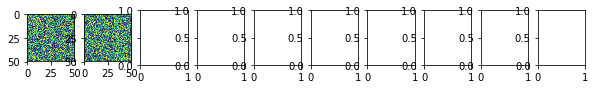

In [54]:
fig2, ax2 = plt.subplots(1, 10, figsize = (10, 1))
ax2[0].set_axis_off()
ax2[1].set_axis_off()
plt.subplot(1, 10, 1)
plt.imshow(np.random.random((50,50)))
plt.subplot(1, 10, 2)
ax2[0].set_axis_off()
ax2[1].set_axis_off()
plt.imshow(np.random.random((50,50)))

plt.show()

numpy.ndarray